In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [6]:
data_id = "08"
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"

In [12]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 17]
print(filtered_data['xAcceleration'].max(),filtered_data['xAcceleration'].min())
print(filtered_data['yAcceleration'].max(),filtered_data['yAcceleration'].min())

-0.02516 -2.28317
1.42541 -0.12597


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

def plot_sv(track_id=0, data_id="00"):
    # File paths
    background_filepath = f"./inD-dataset-v1.1/data/{data_id}_background.png"
    tracks_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracks.csv"
    tracksMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracksMeta.csv"
    
    image = mpimg.imread(background_filepath)
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    ax.imshow(image)
    
    tracks_data = pd.read_csv(tracks_filepath)
    tracksMeta_data = pd.read_csv(tracksMeta_filepath)
    
    num_frames = tracksMeta_data[tracksMeta_data["trackId"] == track_id]["numFrames"].iloc[0]

    for i in range(num_frames):
        sv_info = tracks_data[(tracks_data["trackId"] == track_id) & (tracks_data["frame"] == i)]
        
        if not sv_info.empty:
            x_center = sv_info["xCenter"].iloc[0]
            y_center = sv_info["yCenter"].iloc[0]
            width = sv_info["width"].iloc[0] 
            length = sv_info["length"].iloc[0]
            
            x_lf = x_center - width / 2
            y_lf = y_center - length / 2
            
            rect = patches.Rectangle((x_lf, y_lf), width, length, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.show()

228.3228080481462


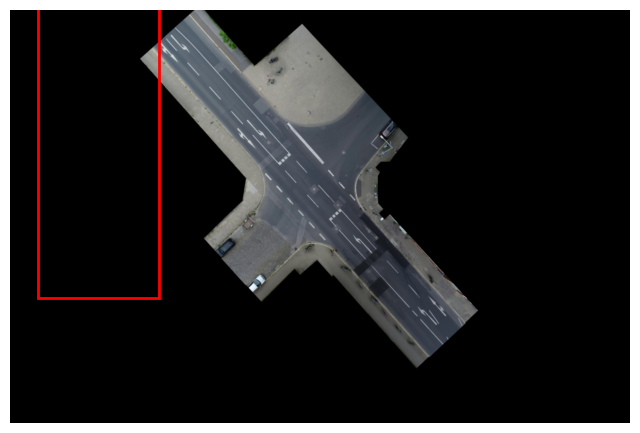

In [9]:
data = pd.read_csv(tracks_filepath)
image = mpimg.imread(background_filepath)
height, width, _ = image.shape
fig, ax = plt.subplots(figsize=(8, 6)) 
plt.imshow(image)
ratio = 0.00814636091724916
print(1.86/ratio)
rect = patches.Rectangle((51.56722,-41.60204), 1.86488/ratio,4.76778/ratio, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [ ]:
import numpy as np
import cvxpy as cp
import mosek
import casadi
from scipy.linalg import sqrtm, svd
import time

class Planner_P( ):
    def __init__(self, Params):
        
        self.T = Params['T']
        self.N = Params['N']
        self.l_f = Params['l_f']
        self.l_r = Params['l_r']
        self.DEV = Params['DEV']
        self.A_SV = Params['A_SV']
        self.B_SV = Params['B_SV']
        self.nx = Params['nx']
        self.nu = Params['nu']
        self.du = Params['du']
        self.Q1 = Params['Q1']
        self.Q2 = Params['Q2']
        self.Q3 = Params['Q3']
        self.v_low = Params['v_low']
        self.v_up = Params['v_up']
        self.acc_low = Params['acc_low']
        self.acc_up = Params['acc_up']
        self.delta_low = Params['delta_low']
        self.delta_up = Params['delta_up']
        self.x_track_sv = Params['x_track_sv']
        self.y_track_sv = Params['y_track_sv']
        self.num_points_sv = Params['num_points_sv']
        self.x_con_c = Params['x_con_c']
        self.y_con_c = Params['y_con_c']
        self.r_in = Params['r_in']
        self.r_out = Params['r_out']
        self.p = Params['p']
        self.margin = Params['margin']
        self.acc_max = Params['acc_max']
        self.collision_tol = Params['collision_tol']
        self.state_tol = Params['state_tol']
        self.Q_measure = Params['Q_measure']
        self.Q_safedis = Params['Q_safedis']
        self.L_State = Params['L_State']
        self.L_Occ   = Params['L_Occ']
        self.H       = Params['H']
        self.h       = Params['h']
        self.MPCFormulation = self.MPCFormulation( )
        self.MPCFormulationBackup = self.MPCFormulationBackup( )
        self.SVMPCFormulation = self.SVMPCFormulation( )
  
    def check_feasibility(self, x_ev, y_ev, v_ev, acc_ev, del_ev):
        
        x_con_c = self.x_con_c
        y_con_c = self.y_con_c
        r_in = self.r_in 
        r_out = self.r_out
        p = self.p

        u_p_inf    = sum(i <= -self.collision_tol for i in 1 - ((x_ev - x_con_c)/r_out)**p - ((y_ev - y_con_c)/r_out)**p)
        l_p_inf    = sum(i <= -self.collision_tol for i in ((x_ev - x_con_c)/r_in)**p + ((y_ev - y_con_c)/r_in)**p - 1 )
        u_v_inf    = sum(i <= -self.state_tol for i in self.v_up - v_ev)
        l_v_inf    = sum(i <= -self.state_tol for i in v_ev - self.v_low)
        u_del_inf  = sum(i <= -self.state_tol for i in self.delta_up - del_ev)
        l_del_inf  = sum(i <= -self.state_tol for i in del_ev - self.delta_low)
        u_acc_inf  = sum(i <= -self.state_tol for i in self.acc_up - acc_ev)
        l_acc_inf  = sum(i <= -self.state_tol for i in acc_ev - self.acc_low)
        
        if (u_p_inf == 0) and (l_p_inf == 0) and (u_v_inf== 0) and (l_v_inf== 0) and (u_del_inf== 0) and (l_del_inf== 0) and (u_acc_inf== 0) and (l_acc_inf== 0) :
            flag = 0 # no collision with road
        else:
            flag = 1 # collision with road

        return flag
    
    def SVPrediction(self, current_x_SV):
        
        distances = np.sqrt((self.x_track_sv - current_x_SV[0])**2 + (self.y_track_sv - current_x_SV[2])**2)
        min_distance_index = np.argmin(distances)

        index_ref = list(range(min_distance_index + 1, min_distance_index + self.N + 1))
        index_ref = [num if num <= (self.num_points_sv-1) else (self.num_points_sv-1) for num in index_ref]

        x_ref_k = self.x_track_sv[index_ref]
        y_ref_k = self.y_track_sv[index_ref]
        
        SVPredictionTrajectory_k = self.SVMPCFormulation(current_x_SV, x_ref_k, y_ref_k)
        SVPredictionTrajectory_k = SVPredictionTrajectory_k.full( )
        
        return SVPredictionTrajectory_k 

    def Minksum_IA(self, q1, Q1, q2, Q2, L):
        q = q1 + q2 
        
        v = sqrtm(Q2)@L
        w = sqrtm(Q1)@L
        v = v/np.linalg.norm(v)
        w = w/np.linalg.norm(w)
        
        Uv, _, Vv = svd(v)  
        Uw, _, Vw = svd(w)  
        
        S2 = Uw*Vw*Vv@Uv.T
        Q = (sqrtm(Q1) + S2@sqrtm(Q2)).T@(sqrtm(Q1) + S2@sqrtm(Q2))
        
        return q, Q

    def Minksum_EA(self, q1, Q1, q2, Q2, L):
        q       = q1 + q2
        Q_Left  = np.sqrt(L.T@Q1@L) + np.sqrt(L.T@Q2@L)
        Q_Right = Q1/np.sqrt(L.T@Q1@L) + Q2/np.sqrt(L.T@Q2@L)
        Q       = Q_Left*Q_Right
        
        return q, Q

    def ReachableSet(self, current_x_SV, Q_k, q_k):
        N = self.N
        nx = self.nx
        du = self.du
        Q_measure = self.Q_measure
        Q_safedis = self.Q_safedis
        A_SV        = self.A_SV
        B_SV        = self.B_SV
        L_State     = self.L_State
        L_Occ       = self.L_Occ
        
        SVPredictionTrajectory_k = self.SVPrediction(current_x_SV)
        x_pre_sv_k  = SVPredictionTrajectory_k[0, :]
        vx_pre_sv_k = SVPredictionTrajectory_k[1, :]
        y_pre_sv_k  = SVPredictionTrajectory_k[2, :]
        vy_pre_sv_k = SVPredictionTrajectory_k[3, :]
        
        q_Bu = B_SV@q_k
        Q_Bu = B_SV@Q_k@B_SV.T + du*np.eye(nx)

        Qr_Inv = np.zeros((2, 2*N)) 
        qr = np.zeros((2, N))
        Reachable_Set_Q = list( )  # exact SV reachable set
        Reachable_Set_q = list( )  # exact SV reachable set
        Linear_State    = list( )   # nominal reachable set

        Reachable_Set_q.append(current_x_SV.reshape(4, 1))
        Reachable_Set_Q.append(Q_measure)
        for t in range(1, N + 1):
            Q_t_1    = Reachable_Set_Q[t-1]
            q_t_1    = Reachable_Set_q[t-1]
            q_t, Q_t = self.Minksum_EA(A_SV@q_t_1, A_SV@Q_t_1@A_SV.T, q_Bu, Q_Bu, L_State)
            
            Reachable_Set_Q.append(Q_t)
            Reachable_Set_q.append(q_t)
            Q_t_reach   = Q_t[:, [0, 2]]
            Q_t_reach   = Q_t_reach[[0, 2], :]
            q_t_reach   = np.array([[x_pre_sv_k[t]], [y_pre_sv_k[t]]])
            _, Q_t      = self.Minksum_EA(q_t_reach, Q_t_reach, np.zeros((2, 1)), Q_safedis, L_Occ)
            heading_ref = np.arctan2(vy_pre_sv_k[t], vx_pre_sv_k[t])
            Q_t_inv     = np.linalg.inv(Q_t)
            eigenvalues, eigenvectors = np.linalg.eig(Q_t_inv)
            major_axis_vector = eigenvectors[:, np.argmin(eigenvalues)]
            heading_current   = np.arctan2(major_axis_vector[1], major_axis_vector[0])

            heading  = heading_ref - heading_current
            rotation = np.array([[np.cos(heading), -np.sin(heading)], [np.sin(heading), np.cos(heading)]])
            
            Q_t_inverse          = rotation@np.linalg.inv(Q_t)@rotation.T
            Qr_Inv[:, 2*t-2:2*t] = Q_t_inverse
            qr[:, t-1]           = q_t_reach.reshape(2, )
        return Qr_Inv, qr, x_pre_sv_k, y_pre_sv_k
    
    def Return(self, current_x_SV, current_x_EV, A_k_1, b_k_1, u_k_1):

        current_x_SV = np.array([current_x_SV[0], current_x_SV[3]*np.cos(current_x_SV[2]), current_x_SV[1], current_x_SV[3]*np.sin(current_x_SV[2])])
        if np.linalg.norm((A_k_1@u_k_1 + b_k_1), 2) <= 1:
            A_k = A_k_1
            b_k = b_k_1
            Qu_k = np.linalg.inv(A_k.T @ A_k)
            qu_k = -np.linalg.inv(A_k)@b_k 
        else:
            A_last = A_k_1.T@A_k_1
            b_last = A_k_1.T@b_k_1
            c_last = b_k_1.T@b_k_1 - 1
            B_k, b_tilde_k = self.SemiDefiProgramming(A_last, b_last.reshape(2, 1), c_last, u_k_1)
            A_k = sqrtm(B_k)
            b_k = np.linalg.inv(A_k)@b_tilde_k
            Qu_k = np.linalg.inv(A_k.T@A_k)
            qu_k = -np.linalg.inv(A_k)@b_k  
            
        Qr_Inv, qr,  x_pre_sv_k, y_pre_sv_k = self.ReachableSet(current_x_SV, Qu_k, qu_k)
        Trajectory_k, Control_k, J_k = self.MPCFormulation(Qr_Inv, qr, current_x_EV)
        Trajectory_k = Trajectory_k.full( )
        Control_k    = Control_k.full( )
        J_k          = J_k.full( )
        
        flag = self.check_feasibility(Trajectory_k[0, 1::], Trajectory_k[1, 1::], Trajectory_k[3, 1::], Control_k[0], Control_k[1])
        if flag == 1:
            Trajectory_k, Control_k, J_k = self.MPCFormulationBackup(current_x_EV)
            Trajectory_k = Trajectory_k.full( )
            Control_k    = Control_k.full( )
            J_k          = abs(J_k.full( ))
            
        return Control_k[:, 0], Trajectory_k, J_k, A_k, b_k, Qu_k, qu_k, Qr_Inv, qr, flag
    
    def SemiDefiProgramming(self, A_last, b_last, c_last, u_last): 
        nu        = self.nu
        B         = cp.Variable((nu, nu), PSD=True) # B = A**2
        tau       = cp.Variable( )
        tau_u     = cp.Variable( )
        b_tilde   = cp.Variable((nu, 1)) # b_tilde = A@b

        A_u = np.eye(nu)
        b_u = -u_last.reshape(2, 1)
        c_u = u_last.T@u_last - self.du

        zero_block = np.zeros((nu, nu))
        
        M  = cp.bmat([[B - tau * A_last, b_tilde - tau * b_last, zero_block],
                     [(b_tilde - tau * b_last).T, cp.reshape(-1 - tau * c_last, (1, 1)), b_tilde.T],
                     [zero_block, b_tilde, -B]])
        Mu = cp.bmat([[B - tau_u * A_u, b_tilde - tau_u * b_u, zero_block],
                     [(b_tilde - tau_u * b_u).T, cp.reshape(-1 - tau_u * c_u, (1, 1)), b_tilde.T],
                     [zero_block, b_tilde, -B]])
        
        constraints = [tau >= 0, tau_u >= 0, -M >> 0, -Mu >> 0, B - 1e-8*np.eye(nu) >> 0]  
        objective   = cp.Maximize(cp.log_det(B))
        problem     = cp.Problem(objective, constraints)
        problem.solve(solver = cp.MOSEK)

        return B.value, b_tilde.value
    
    def MPCFormulation(self):
        N   = self.N
        DEV = self.DEV
        T   = self.T
        Q1  = self.Q1
        Q2  = self.Q2
        Q3  = self.Q3
        x_con_c = self.x_con_c
        y_con_c = self.y_con_c
        r_in    = self.r_in
        r_out   = self.r_out
        p       = self.p
 
        v_low     = self.v_low 
        v_up      = self.v_up 
        acc_low   = self.acc_low 
        acc_up    = self.acc_up 
        delta_low = self.delta_low 
        delta_up  = self.delta_up

        opti  = casadi.Opti( )
        X     = opti.variable(DEV, N + 1)
        U     = opti.variable(2, N)
        acc   = U[0, :]
        delta = U[1, :]

        Q_Inv = opti.parameter(2, 2*N)
        q = opti.parameter(2, N)
        Initial = opti.parameter(DEV, 1)
    
        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], acc[k], delta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, acc[k], delta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, acc[k], delta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3,   acc[k], delta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 

        v       = X[3, 1::]
        v_error = v[-1] - self.v_up
 
        for k in range(N):
            p_point = X[0:2, k + 1]
            
            Q_k_Inv = Q_Inv[:, 2*k:2*k + 2]
            q_k = q[:, k]
            opti.subject_to(1 <= (p_point - q_k).T@Q_k_Inv@(p_point - q_k))
            opti.subject_to(1 <= ((p_point[0] - x_con_c)/r_in)**p + ((p_point[1] - y_con_c)/r_in)**p)
            opti.subject_to(((p_point[0] - x_con_c)/r_out)**p + ((p_point[1] - y_con_c)/r_out)**p <= 1)

        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, acc, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + acc@Q2@acc.T +  Q3*v_error@v_error.T 
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "ipopt.linear_solver": "ma57", "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('g', [Q_Inv, q, Initial], [X, U, J])
    
    def MPCFormulationBackup(self):
        N = self.N
        DEV = self.DEV
        T = self.T
        x_con_c = self.x_con_c
        y_con_c = self.y_con_c
        r_in = self.r_in
        r_out = self.r_out
        p = self.p
 
        v_low = self.v_low 
        v_up = self.v_up 
        acc_low = self.acc_low 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = casadi.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        acc   = U[0, :]
        delta = U[1, :]
        
        Initial = opti.parameter(DEV, 1)
    
        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], acc[k], delta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, acc[k], delta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, acc[k], delta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3,   acc[k], delta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 

        v     = X[3, 1::]
        for k in range(N):
            p_point = X[0:2, k + 1]
            opti.subject_to(1 <= ((p_point[0] - x_con_c)/r_in)**p + ((p_point[1] - y_con_c)/r_in)**p)
            opti.subject_to(((p_point[0] - x_con_c)/r_out)**p + ((p_point[1] - y_con_c)/r_out)**p <= 1)

        opti.subject_to(acc[0] == -self.acc_max)
        opti.subject_to(acc[1] == -self.acc_max)
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(-self.acc_max, acc, self.acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = -acc@acc.T
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "ipopt.linear_solver": "ma57", "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('g', [Initial], [X, U, J])

    def  vehicle_model(self, w, acc, delta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta      = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        
        x_dot     = w[3]*np.cos(w[2] + beta) 
        y_dot     = w[3]*np.sin(w[2] + beta)
        phi_dot   = w[3]/(l_r)*np.sin(beta)
        v_dot     = acc
        
        return casadi.vertcat(x_dot, y_dot, phi_dot, v_dot)
    
    def  vehicle_model_sim(self, w, acc, delta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta      = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        
        x_dot     = w[3]*np.cos(w[2] + beta) 
        y_dot     = w[3]*np.sin(w[2] + beta)
        phi_dot   = w[3]/(l_r)*np.sin(beta)
        v_dot     = acc
        
        return np.array([x_dot, y_dot, phi_dot, v_dot])

    def SVMPCFormulation(self):
        N = self.N
        T = self.T

        opti = casadi.Opti( )
        X = opti.variable(4, N + 1)
        U = opti.variable(2, N)
        ax   = U[0, :]
        ay   = U[1, :]
        
        Initial = opti.parameter(4, 1)
        x_ref = opti.parameter(1, N)
        y_ref = opti.parameter(1, N)
        U_A = opti.parameter(4, 2)
        U_b = opti.parameter(4, 1)
        
        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.SV_vehicle_model(X[:, k], ax[k], ay[k])
            k2 = self.SV_vehicle_model(X[:, k] + T/2*k1, ax[k], ay[k])
            k3 = self.SV_vehicle_model(X[:, k] + T/2*k2, ax[k], ay[k])
            k4 = self.SV_vehicle_model(X[:, k] + T*k3,   ax[k], ay[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
            opti.subject_to(self.H@U[:, k] <= self.h)
            
        x = X[0, 1::]
        y = X[2, 1::]
        
        x_error   = x - x_ref
        y_error   = y - y_ref 
        
        J = x_error@x_error.T + y_error@y_error.T
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "ipopt.linear_solver": "ma57", "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('g', [Initial, x_ref, y_ref], [X])

    def  SV_vehicle_model(self, w, ax, ay):
        
        x_dot  = w[1]
        vx_dot = ax
        y_dot  = w[3]
        vy_dot = ay
        
        return casadi.vertcat(x_dot, vx_dot, y_dot, vy_dot)